In [ ]:
# Install necessary packages
!pip install -Uqq fastbook
!pip install -U fastai

# Import required libraries
import fastbook
from fastai.vision.all import *
from google.colab import drive
from PIL import ImageFile
import torchvision

# Set up Fastbook
fastbook.setup_book()

In [ ]:
# define paths for train and test data
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

train_path = root_dir+'datasets/451/train'
test_path = root_dir+'datasets/451/test'

Mounted at /content/gdrive


In [ ]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create a function to split the dataset into training and validation sets
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

# Create a DataBlock for the images
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(128),  # Change the resize dimensions to 128
    batch_tfms=aug_transforms(),  # Add data augmentation
    splitter=RandomSplitter(valid_pct=0.2, seed=42)  # Use 20% of the training data for validation
)

# Create DataLoaders using the DataBlock
dls = datablock.dataloaders(train_path, bs=32)


In [ ]:
print(f"Number of training batches: {len(dls.train)}")
print(f"Number of validation batches: {len(dls.valid)}")

Number of training batches: 130
Number of validation batches: 33


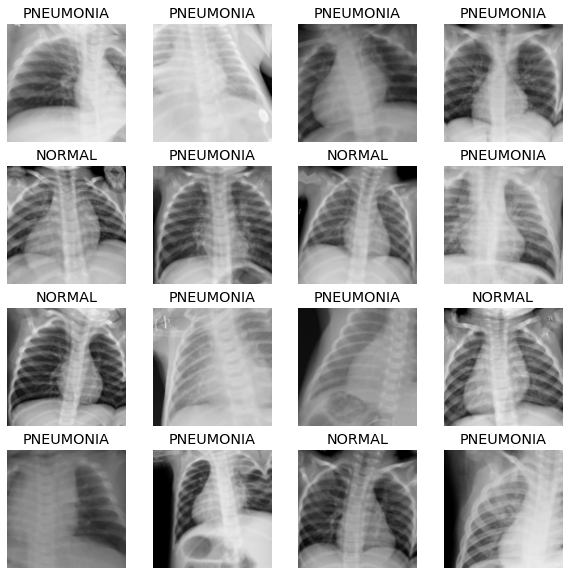

In [ ]:
# Visualize a batch of images
dls.show_batch(max_n=16, figsize=(10, 10))

In [ ]:
# Define the custom CNN model
class MultCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = None  # initialize this later
        self.fc2 = nn.Linear(128, num_classes)
        self.flattened_size = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool(x)
        if self.flattened_size is None:
            self.flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flattened_size, 128).to(x.device) 
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
num_classes = len(dls.vocab)  # Get the number of classes from the DataLoaders object
model = MultCNN(num_classes)  # Create an instance of the custom model

epoch,train_loss,valid_loss,accuracy,time
0,0.385969,0.250675,0.910134,00:22


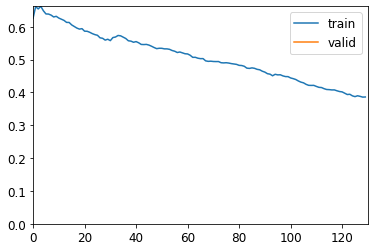

epoch,train_loss,valid_loss,accuracy,time
0,0.260344,0.207601,0.920650,00:22
1,0.249011,0.981880,0.552581,00:22
2,0.223750,1.292912,0.498088,00:22
3,0.198612,0.502972,0.794455,00:21
4,0.201219,0.451347,0.813576,00:22
5,0.187912,0.404581,0.839388,00:21
6,0.171672,0.252250,0.903442,00:21
7,0.177397,0.353652,0.854685,00:21
8,0.169859,0.321560,0.868069,00:21
9,0.178331,0.246835,0.904398,00:22


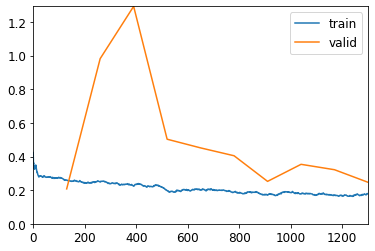

In [ ]:
# Create a learner object with the custom CNN model
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy, cbs=[ShowGraphCallback()])

learn.fine_tune(10)  # Train Model

In [ ]:
# Create a DataBlock for the test images
test_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(128),  # Change the resize dimensions to 128
)

# Load the test dataset
test_dl = test_datablock.dataloaders(test_path, bs=64)


In [ ]:
# Evaluate the model on the test set
learn.validate(dl=test_dl.train)


(#2) [0.26903393864631653,0.890625]

In [ ]:
# Extract the predicted probabilities and true labels from the test set results
test_preds, test_labels = learn.get_preds(dl=test_dl.train)
pred_probas = test_preds.numpy()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Convert probabilities to class labels
pred_classes = np.argmax(pred_probas, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, pred_classes)
print(f"Test set accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1-score, and support for each class
report = classification_report(test_labels, pred_classes, target_names=dls.vocab, output_dict=True)

print("Classification Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"{label.capitalize()}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Test set accuracy: 0.8840
Classification Report:
Normal:
  precision: 0.8663
  recall: 0.8308
  f1-score: 0.8482
  support: 195.0000
Pneumonia:
  precision: 0.8946
  recall: 0.9180
  f1-score: 0.9061
  support: 305.0000
Macro avg:
  precision: 0.8804
  recall: 0.8744
  f1-score: 0.8772
  support: 500.0000
Weighted avg:
  precision: 0.8835
  recall: 0.8840
  f1-score: 0.8835
  support: 500.0000
